In [257]:
%matplotlib inline 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [111]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [284]:
vgg = list(torchvision.models.vgg19_bn(pretrained=True).features[:-1].children())
vgg = nn.Sequential(*[nn.AvgPool2d(2) if isinstance(n, nn.MaxPool2d) else n for n in vgg]).to(dev)
for param in vgg.parameters():
    param.requires_grad = False

In [285]:
# All conv layers. Replace maxpool with average as proposed in paper?
conv_ids = [int(idx) for idx, m in vgg.named_children() if isinstance(m, nn.Conv2d)]
len(conv_ids)

16

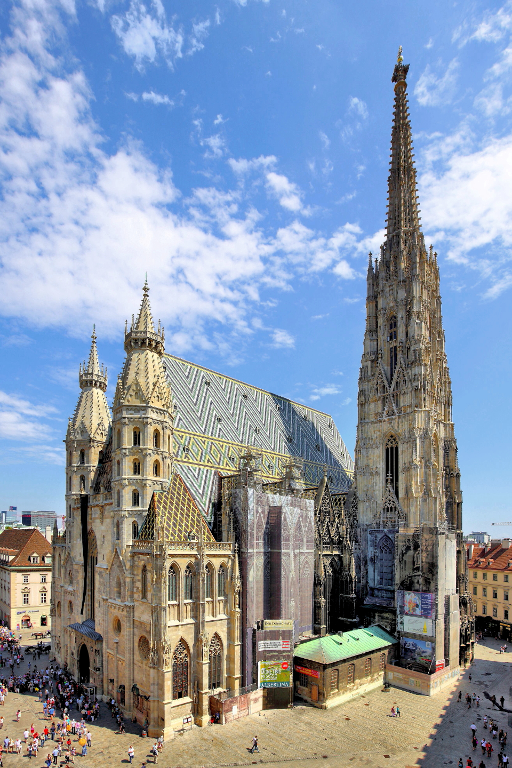

In [286]:
p = Image.open('stephansdom_small.png')
p

In [287]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

t = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)    
])

def denormalize(tensor):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return transforms.ToPILImage()(tensor)

In [288]:
pt = t(p)

In [289]:
def content_loss(a, b):
    return F.mse_loss(a, b, size_average=True)

In [304]:
from tqdm import tqdm

class GrabActivations:    
    def __call__(self, module, inputs, outputs):
        self.activations = outputs

def reconstruct(net, dev, layer_id, crit, image, niter=100, lr=1e-2):
    
    grab = GrabActivations()    
    
    image = image.to(dev).unsqueeze(0)   

    with net[layer_id].register_forward_hook(grab):
        net(image)
        act_ref = grab.activations.clone()   
        
    x = torch.randn_like(image, requires_grad=True).to(dev)
    
    with net[layer_id].register_forward_hook(grab), tqdm(total=niter) as t:
        
        for idx in range(niter):
    
            if x.grad is not None:
                x.grad.zero_()

            net(x)
            act_x = grab.activations

            loss = crit(act_ref, act_x)
            loss.backward()                
            x.data.sub_(x.grad * lr)
            
            t.set_postfix(loss=loss.item(), grad=torch.norm(x.grad).item())
            t.update()
            
        return x        

In [309]:
layer_id = conv_ids[2]
x = reconstruct(vgg, dev, layer_id, content_loss, pt, niter=1000, lr=1e5)
xx = denormalize(x.squeeze().cpu())

100%|████████████████████████████████████████████████| 1000/1000 [01:49<00:00,  9.11it/s, grad=2.96e-06, loss=0.000847]


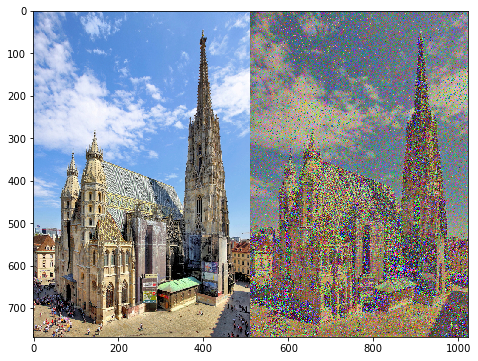

In [310]:
plt.figure(figsize=(12,6))
plt.imshow(np.hstack((np.array(p), np.array(xx))))